# Alanine dipeptide

Alanine dipeptide is small organic molecule where its geometry is almost expressed with two collective variables, $\phi$ and $\psi$. $\phi$ and $\psi$ each indicates the diheadral angles (torsion) between centered $C$ atoms and its neighboring two atoms respectively. 

Here, we will going to find multiple pathways of the alaine dipeptide. We used ab initio package VASP, one can use other calculating using slight modification on `calc`. Coordinates system of the alanine dipeptide is
```
[-81.89, 71 -> 71.05, -60.29]
C70 : phi = -8.537736562175269e-07 psi = 8.537736462515939e-07
C7eq : phi = -81.89 psi = 74.0
C7ax : phi = 71.05 psi = -59.29
```

In [1]:
import numpy as np
from taps.coords import Cartesian

N = 300
phi = np.linspace(-81.89, 71.05, N)
psi = np.linspace( 74.05, -59.3, N)

coords = Cartesian(coords=np.array([phi, psi])* np.pi / 180, epoch=6, unit='deg')

# Inverse Projector

 We have represented our system with two angles but to calculate potential energy surface (PES), it is essential to recovor original atomic geometry from collective variables. That is we need, for a given $\theta$ and $\psi$, we need a map that sends two coordinate into 22 atoms. Coordinates where we can calculate physical properties of it. Process of inverse projection is tedious, this prepared a pre-scripted code that exactly does that. This script generate the C70 coordinates which represents the $\phi$ and $\psi$ (0., 0.) and rotate the atoms to match to that angles. 

In [3]:
from taps.projectors.alaninedipeptide import AlaninedipeptideInverse
prj = AlaninedipeptideInverse()
print("Before: ", coords.shape)
print("After : ", prj.x(coords).shape)

Before:  (2, 300)
After :  (3, 22, 300)


# Trajectory writing

Someone might want to check this code is indeed working properly, one who want that, use the code below. 

```python
from ase.atoms import Atoms
image = Atoms('HCHHCONHCHCHHHCONHCHHH', cell=[15,15,15], pbc=True)
new_coords = prj.x(coords)
filename="test.traj"
from ase.io.trajectory import TrajectoryWriter
trj = TrajectoryWriter(filename, mode="a")
N = new_coords.shape[-1]
#image = self.image.copy()
for n in range(N):
    positions = new_coords[:, :, n].T
    image.positions = positions
    trj.write(image)
```

# VASP calculator

 From the projected coordinates generated above, we are going to optimize the structure while keeping two dihedral angles. Our model will uses *ab initio* pacakge VASP. Unfortunatley, current implementation on `ASE` does not fully support all the functions on the VASP. Below codes inherits the original `Vasp` class in the ASE and modify slightly suits that suits our needs. For example, we are going to fix the dihedral angles which needs `ICONST`, we will generate that. Additionlly, to avoid similar calculation, if it finds the `OUTCAR` that has same coordinates withint 0.1 range, it uses that coordinates. 

<!---
#from ase.calculators import calculator
#properties=["free_energy"]
#all_changes = tuple(calculator.all_changes)
#calc.write_input(image, ['free_energy'], all_changes)
-->

In [4]:
import os
from ase.calculators.vasp import Vasp
from ase.calculators.vasp.vasp import check_atoms
from ase.calculators import calculator


class Myvasp(Vasp):
    def calculate(self, atoms=None, properties=('energy',),
                  system_changes=tuple(calculator.all_changes)):
        """Do a VASP calculation in the specified directory.

        This will generate the necessary VASP input files, and then
        execute VASP. After execution, the energy, forces. etc. are read
        from the VASP output files.
        """
        check_atoms(atoms)
        
        self.clear_results()

        if atoms is not None:
            self.atoms = atoms.copy()

        command = self.make_command(self.command)
        self.write_input(self.atoms, properties, system_changes)

        olddir = os.getcwd()
        try:
            os.chdir(self.directory)
            if os.path.isfile('OUTCAR'):
                print(self.prefix, 'exist')
                errorcode = None
                pass
            else:
                
                #with open('ICONST', 'w') as f:
                #    f.write('T 14 21 15 17 0\nT 21 15 17 22 0')
                with open('POSCAR', 'a+') as f:
                    arr = np.random.normal(0, 0.1, (22, 3))
                    f.write('\n'.join('\t'.join('%0.3f' %x for x in y) for y in arr))
                # Create the text output stream and run VASP
                os.chdir(olddir)
                with self._txt_outstream() as out:

                    errorcode = self._run(command=command, 
                                          out=out,
                                          directory=self.directory)
        finally:
            os.chdir(olddir)

        if errorcode:
            raise CalculationFailed(
                '{} in {} returned an error: {:d}'.format(
                self.name, self.directory, errorcode))

        # Read results from calculation
        self.update_atoms(atoms)
        self.read_results()

calculator.register_calculator_class('Myvasp', Myvasp)

# Atomic model

 For the atomic construction, we use Atomic Simulation Environment (ASE) package. With the `Atoms` class in the ASE, we can create `image`, instance of `Atoms` class, as reference atomic properties calculation. All the parameters in the `image` except the `positions` will be used in the data generation in the `AtomicModel`, TAPS. We pre-scripted the `Alainedipeptide` model class which inherits the `AtomicModel`, for special naming method of the atomic calculation for naming the results.  

In [ ]:
from ase.atoms import Atoms

image = Atoms('HCHHCONHCHCHHHCONHCHHH', cell=[15,15,15], pbc=True)
calc = Myvasp(prec='normal', algo='fast',
                   command = 'mpirun -np 40 vasp_gam',
                   nelmin=4, ncore=4, maxmix=20, ismear=0,
                   isym=-1, istart=2,
                   smass=-2,
                  # ibrion=0, mdalgo=1, andersen_prob=0.05, potim=1, tebeg=0,nsw=1,
                  ibrion=0, mdalgo=1, andersen_prob=0.05, potim=1, tebeg=0,nsw=500,
                   ediffg= -0.001, encut=520, ediff=1e-5,
                   isif=0, xc='pbe', ivdw=11, lcharg=True)

image.set_velocities(np.random.normal(0, 0.1, (22, 3)))
image.calc = calc

In [6]:
from taps.paths import Paths
from taps.db.data import ImageData
from taps.ml import Gaussian
from taps.ml.kernels import PeriodicKernel
from taps.model.atomicmodel import AlanineDipeptide
model = AlanineDipeptide(image=image, prj=prj,
                         set_directory=True, directory='./test/vasp/')
 
hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-4, 
                   'sigma_n^e':1e-4, 'l^2': 1}
hyperparameters_bounds = {'sigma_f': (1e-6, 1e4), 'sigma_n^f': (1e-6, 1e-3), 
                          'sigma_n^e':(1e-5, 1e-3), 'l^2': (1e-4, 4)}
model = Gaussian(real_model=model,
                 kernel=PeriodicKernel(),
                 hyperparameters=hyperparameters,
                 hyperparameters_bounds=hyperparameters_bounds)

directory = "./test/"
imgdata = ImageData("./test/alaine_test.db")
paths = Paths(coords=coords, model=model, imgdata=imgdata)
paths.add_data(index=[0, paths.N//2, -1])

# Paths construction

In [8]:
from taps.visualize import view
view(paths, viewer="Alaninedipeptide", gaussian=True)

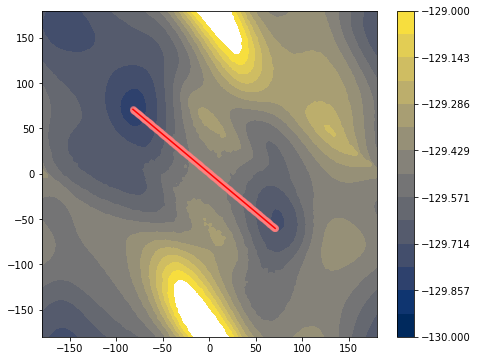

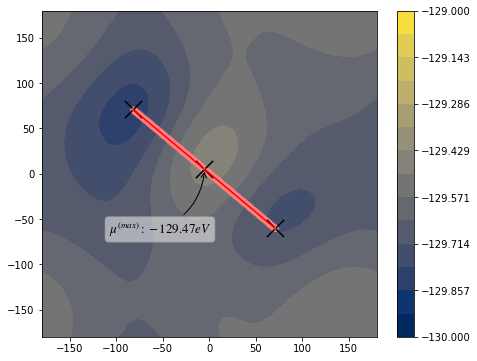

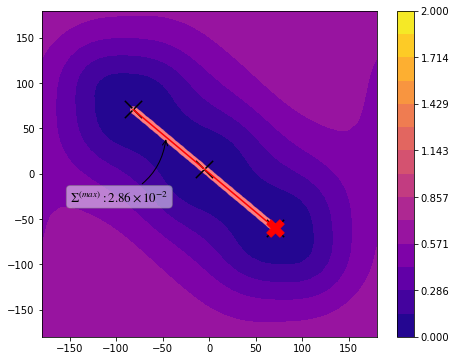

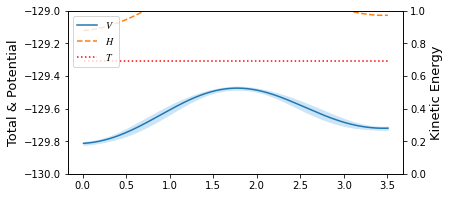

In [11]:
paths.model.hyperparameters

{'sigma_f': 0.8963721230341252,
 'l^2': 1.3096166754610017,
 'sigma_n^e': 8.918233340655752e-05,
 'sigma_n^f': 8.810056674721327e-05}

In [12]:
import numpy as np
from taps.coords import Cartesian

N = 300
phi = np.linspace(-81.89, 71.05, N)
psi = np.linspace( 71.05, -60.29, N)

coords = Cartesian(coords=np.array([phi, psi])* np.pi / 180, epoch=6, unit='deg')

In [ ]:
from taps.paths import Paths
from taps.db.data import ImageData
from taps.ml import Gaussian
from taps.ml.kernels import PeriodicKernel
from taps.model.atomicmodel import AlanineDipeptide
from taps.pathfinder import DAO, GPAO

directory = "./test/"
imgdata = ImageData(directory + "alaine_test.db")

model = AlanineDipeptide(image=image, prj=prj,
                         set_directory=True, directory='./test/vasp/')
 
hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-4, 
                   'sigma_n^e':1e-4, 'l^2': 1}
hyperparameters_bounds = {'sigma_f': (1e-6, 1e4), 'sigma_n^f': (1e-6, 1e-3), 
                          'sigma_n^e':(1e-5, 1e-3), 'l^2': (1e-4, 4)}
model = Gaussian(real_model=model,
                 kernel=PeriodicKernel(),
                 hyperparameters=hyperparameters,
                 hyperparameters_bounds=hyperparameters_bounds)

finder = DAO(prj_search=False, action_name=["Onsager Machlup", "Energy conservation"],
             Et=-129.8, muE=1., gam=1.)
finder = GPAO(real_finder=finder, 
              label= directory + "gpao_5/1", phases=["auto et"], 
              plot=view)

paths = Paths(coords=coords, model=model, finder=finder, imgdata=imgdata)

paths.add_data(index=[0, paths.N//2, -1])

paths.search()

#view(paths, viewer="Alaninedipeptide", gaussian=True)

# Effective mass

Since we are approximating the, kinetic energy becomes 

it shifts. AlanineGaussian

In [ ]:
from taps.model.alaninedipeptide import AlanineGaussian

model = AlanineGaussian(real_model=model.real_model, kernel=Sine(),
                        hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-2, 
                                           'sigma_n^e':1e-6,'l^2': 0.1},
                        hyperparameters_bounds = {'sigma_f': (1, 1), 'sigma_n^f': (1e-3, 1e-1), 
                                           'sigma_n^e':(1e-6, 1e-4), 'l^2': (1e-4, 4)})

In [23]:
calc.write_input(image, ['free_energy'], all_changes)

In [ ]:
from ase.calculator import calculator

In [16]:

tuple(calculator.all_changes)

('positions', 'numbers', 'cell', 'pbc', 'initial_charges', 'initial_magmoms')

In [15]:
5 + (np.array([1, 2]) < 4)

array([6, 6])

In [26]:
image.get_velocities()

array([[ 0.11521139, -0.04229535, -0.02673665],
       [-0.04540874, -0.1071065 ,  0.09930575],
       [-0.15032989, -0.01451226, -0.03128089],
       [-0.13935848,  0.11298622, -0.10846736],
       [ 0.11840371, -0.02380525,  0.03487724],
       [ 0.0395002 ,  0.04408586, -0.0417576 ],
       [-0.13077404,  0.00619305,  0.03044093],
       [ 0.16051461, -0.11844937,  0.0777218 ],
       [-0.15388187, -0.0592287 ,  0.15220838],
       [ 0.05871047,  0.03282886,  0.04172938],
       [ 0.01288722,  0.13164861, -0.17965177],
       [-0.11095385, -0.07839192,  0.04201723],
       [ 0.24567347,  0.17463638,  0.09762216],
       [ 0.09855363,  0.1871649 ,  0.02309504],
       [ 0.00157576,  0.12208455, -0.04897028],
       [-0.31671403, -0.31146976,  0.04570274],
       [ 0.0292931 , -0.15617332, -0.0260643 ],
       [-0.27088246, -0.03723309, -0.0802822 ],
       [ 0.0252782 , -0.02731277,  0.09481231],
       [ 0.02925227,  0.03479341, -0.05307947],
       [-0.02555791,  0.02123364, -0.016

In [36]:
image.set_momenta()

array([[ 0.11613308, -0.04263372, -0.02695054],
       [-0.54540442, -1.28645621,  1.19276132],
       [-0.15153253, -0.01462836, -0.03153113],
       [-0.14047334,  0.11389011, -0.1093351 ],
       [ 1.42214692, -0.28592484,  0.41891057],
       [ 0.63196363,  0.70532966, -0.66807991],
       [-1.83175199,  0.08674609,  0.42638605],
       [ 0.16179872, -0.11939696,  0.07834358],
       [-1.84827509, -0.71139591,  1.82817491],
       [ 0.05918016,  0.03309149,  0.04206322],
       [ 0.15478845,  1.58123145, -2.15779742],
       [-0.11184148, -0.07901905,  0.04235336],
       [ 0.24763886,  0.17603347,  0.09840314],
       [ 0.09934206,  0.18866222,  0.0232798 ],
       [ 0.01892643,  1.46635754, -0.58818208],
       [-5.06710772, -4.98320469,  0.73119816],
       [ 0.41030849, -2.18751971, -0.36508261],
       [-0.27304952, -0.03753095, -0.08092446],
       [ 0.30361644, -0.32805366,  1.1387906 ],
       [ 0.02948629,  0.03507175, -0.0535041 ],
       [-0.02576238,  0.02140351, -0.016

In [29]:
atom = image[0]
atom

Atom('H', [3.1237571510408344, 8.746213759090187, 7.978653697279056], momentum=[0.1161330776204833, -0.04263371720783947, -0.026950540839431526], index=0)

In [31]:
atom.momentum

array([ 0.11613308, -0.04263372, -0.02695054])

# VASP Alanine dipeptide with velocity applied



In [ ]:
# VASP Model
from ase.calculators.vaspnode import Vaspnode
from ase.calculators.calculator import register_calculator_class
register_calculator_class('Vaspnode', Vaspnode)
# label='/group/schinavro/alanine/vasp_periodic/dyn/dyn'
vasp = Vaspnode(   prec='normal', algo='fast',
                   command = 'vasp_gam',
                   nelmin=4, ncore=4, maxmix=20, ismear=0,
                   isym=-1, istart=0,
                   smass=-2,
                   ibrion=0, mdalgo=1, andersen_prob=0.05, potim=1, tebeg=0,nsw=500,
                   ediffg= -0.001, encut=520, ediff=1e-5,
                   isif=0, xc='pbe', ivdw=11, lcharg=False)
import numpy as np
from ase.pathway.paths import Paths
from ase.pathway.model import FlatModel
from ase.pathway.data import AtomsData
from ase.pathway.pathfinder import ADMD
from ase.pathway.plotter import FlatModelPlotter

from ase.pathway.gaussian import Gaussian, GaussianSearch
N = 300
x, y = np.linspace(-1, 1, N), np.linspace(-1, 1, N)
coords = np.array([[x], [y]])
directory = '/group/schinavro/flatTest/test9'
prefix = 'test'
model = FlatModel()
model = Gaussian(real_model=model,
                 hyperparameters = {'sigma_f': 1, 'sigma_n^f': 1e-2, 'sigma_n^e':1e-6,'l^2': 0.1},
                 hyperparameters_bounds = {'sigma_f': (1, 1), 'sigma_n^f': (1e-3, 1e-1), 'sigma_n^e':(1e-6, 1e-4), 'l^2': (1e-4, 4)})
finder = ADMD(action_name=['Onsager Machlup'], tol=0.005)
finder = GaussianSearch(real_finder=finder, phases=['auto et'])
atomsdata = AtomsData(filename=directory + '/descriptor.db')
plotter = FlatModelPlotter(mapfile=directory + '/plotter_map.pkl')
paths = Paths('H', coords, label=directory + '/' + prefix,
              model=model,
              finder=finder,
              plotter=plotter)

In [ ]:
from taps.model.alanine import AlaninedipeptideModel
from taps.ml import Gaussian



vasp = Vaspnode(   prec='normal', algo='fast',
                   command = 'vasp_gam',
                   nelmin=4, ncore=4, maxmix=20, ismear=0,
                   isym=-1, istart=0,
                   smass=-2,
                   ibrion=0, mdalgo=1, andersen_prob=0.05, potim=1, tebeg=0,nsw=500,
                   ediffg= -0.001, encut=520, ediff=1e-5,
                   isif=0, xc='pbe', ivdw=11, lcharg=False)

model = AlaninedipeptideModel("")
model = Gaussian(real_model=model, hyperparameters...)


In [ ]:
paths.add_data("djafh")

In [ ]:
from taps.pathfinder import DAO

finder = DAO()

finder = GPAO(real_finder = finder, ...)


paths.finder = finder

In [ ]:
def calculate(self, atoms=None, properties=['energy'],
                  system_changes=all_changes):
        """Do a VASP calculation in the specified directory.

        This will generate the necessary VASP input files, and then
        execute VASP. After execution, the energy, forces. etc. are read
        from the VASP output files.
        """

        if atoms is not None:
            self.atoms = atoms.copy()

        self.check_cell()      # Check for zero-length lattice vectors
        self._xml_data = None     # Reset the stored data

        command = self.make_command(self.command)
        self.write_input(self.atoms, properties, system_changes)

        olddir = os.getcwd()
        try:
            os.chdir(self.directory)
            if os.path.isfile('OUTCAR'):
                print(self.prefix, 'exist')
                errorcode = None
                pass
            else:
                with open('ICONST', 'w') as f:
                    f.write('T 14 21 15 17 0\nT 21 15 17 22 0')
                with open('POSCAR', 'a+') as f:
                    arr = np.random.normal(0, 0.1, (22, 3))
                    f.write('\n'.join('\t'.join('%0.3f' %x for x in y) for y in arr))
                # Create the text output stream and run VASP
                with self.txt_outstream() as out:
                    errorcode = self._run(command=command, out=out)
            
        finally:
            os.chdir(olddir)

        if errorcode:
            raise CalculationFailed('{} in {} returned an error: {:d}'.format(
                self.name, self.directory, errorcode))

        # Read results from calculation
        self.update_atoms(atoms)
        self.read_results()


# Atoms

image

In [8]:
image

NameError: name 'image' is not defined

# Velocity writing



In [ ]:
from ase.vasp.vasp import Vasp

Vasp

In [ ]:
population.........



# Inverse mask

To reduce the masking process it is better to do everything in the masked space...... but no

Alanine dipeptide inverse mask projector, we send phi psi to full coordinates. Because of this coordinates are not stable, we relaxed through the ??



# I have to run that... with new code scheme

In [ ]:
from taps.coords import Coords

coords = np.ze